# Setup

In [254]:
import ugradio
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import lstsq, inv, norm
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift
from scipy.stats import norm, linregress
from scipy.optimize import curve_fit, least_squares
from scipy.signal import find_peaks, stft
from scipy.special import j1
from uncertainties import ufloat
from dataclasses import dataclass
from typing import Dict, Optional, Tuple
import os
from astropy.time import Time
from astropy.coordinates import EarthLocation
import astropy.units as u
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [255]:
# Consistent Plot Params
titleSize = 15
axisSize = 15
legendSize = 13
graphSizeSingle = (8, 6)
graphSizeDouble = (15, 6)
graphSizeHorizontal = (20, 6)

# Data Extraction & Cleansing

In [256]:
def extractSdrCalData(sdr_0_paths, sdr_0_cal_paths, sdr_1_paths, sdr_1_cal_paths, normalize=True, pickling=False):
    prefix = "ugastro\\Lab4Data\\"
    sdr_data, cal_data = [[], []], [[], []]
    if normalize:
        for path_0, path_1 in zip(sdr_0_paths, sdr_1_paths):
            sdr_data[0].append(subtractMean(np.load(prefix+path_0, allow_pickle=pickling)))
            sdr_data[1].append(subtractMean(np.load(prefix+path_1, allow_pickle=pickling)))

        for path_0, path_1 in zip(sdr_0_cal_paths, sdr_1_cal_paths):
            cal_data[0].append(subtractMean(np.load(prefix+path_0, allow_pickle=pickling)))
            cal_data[1].append(subtractMean(np.load(prefix+path_1, allow_pickle=pickling)))
    else:
        for path_0, path_1 in zip(sdr_0_paths, sdr_1_paths):
            sdr_data[0].append(np.load(prefix+path_0, allow_pickle=pickling))
            sdr_data[1].append(np.load(prefix+path_1, allow_pickle=pickling))

        for path_0, path_1 in zip(sdr_0_cal_paths, sdr_1_cal_paths):
            cal_data[0].append(np.load(prefix+path_0, allow_pickle=pickling))
            cal_data[1].append(np.load(prefix+path_1, allow_pickle=pickling))
    return sdr_data, cal_data

def extractSdrData(sdr_0_paths, sdr_1_paths, normalize=False, pickling=False):
    prefix = "ugastro\\Lab4Data\\"
    sdr_data = [[], []]
    if normalize:
        for path_0, path_1 in zip(sdr_0_paths, sdr_1_paths):
            sdr_data[0].append(subtractMean(np.load(prefix+path_0, allow_pickle=pickling)))
            sdr_data[1].append(subtractMean(np.load(prefix+path_1, allow_pickle=pickling)))
    else:
        for path_0, path_1 in zip(sdr_0_paths, sdr_1_paths):
            sdr_data[0].append(np.load(prefix+path_0, allow_pickle=pickling))
            sdr_data[1].append(np.load(prefix+path_1, allow_pickle=pickling))
    return sdr_data

def subtractMean(data):
    return data - np.mean(data)

In [257]:
@dataclass
class PointData:
    id: int
    l: float
    b: float
    ra: float
    dec: float
    LSB: Optional[np.ndarray] = None
    USB: Optional[np.ndarray] = None
    is_calibration: bool = False
    timestamp: str = ""

@dataclass
class MapData:
    l: float
    b: float
    velocity: float
    brightness: float

def extractSdrPoints(base_path, normalize=False, correction="") -> Dict[int, Dict[int, PointData]]:
    # Dictionary of two SDRs (device_index 0 & 1)
    data = {
        0: {"normal": [], "calibration": []},
        1: {"normal": [], "calibration": []}
    }

    prefix = "ugastro\\Lab4Data\\"
    for sdr_index in [0, 1]:
        pol_folder = os.path.join(prefix+base_path, f"pol{sdr_index}")
        if not os.path.isdir(pol_folder):
            print(f"Warning: Folder {pol_folder} not found.")
            continue

        for fname in os.listdir(pol_folder):
            if fname.endswith(".npz") and fname.startswith("obs_"):
                # Parse the filename: obs_{point_id}_{mode}.npz
                parts = fname.replace(correction+".npz", "").split("_")
                try:
                    point_id = int(parts[1])
                    mode = "_".join(parts[2:])  # "LSB" or "USB"
                except (IndexError, ValueError):
                    print(f"Skipping unrecognized file: {fname}")
                    continue

                file_path = os.path.join(pol_folder, fname)
                try:
                    with np.load(file_path) as npzfile:    
                        spectrum = npzfile['spectrum']
                        if normalize:
                            spectrum = spectrum / np.max(spectrum)

                        point = PointData(
                            id=point_id,
                            l=npzfile["gal_l"].item(),
                            b=npzfile["gal_b"].item(),
                            ra=npzfile["ra"].item(),
                            dec=npzfile["dec"].item(),
                            is_calibration=bool(npzfile["is_calibration"].item()),
                            timestamp=str(npzfile["timestamp"])
                        )

                        if mode == "LSB":
                            point.LSB = spectrum
                            point.USB = None
                            point.is_calibration = False
                        elif mode == "USB":
                            point.USB = spectrum
                            point.LSB = None
                            point.is_calibration = False
                        elif mode == "cal_on":
                            point.USB = spectrum
                            point.is_calibration = True
                        else:
                            print(f"Unknown mode: {mode} in file {fname}")

                        if mode not in ("USB", "LSB"):
                            data[sdr_index]["calibration"].append(point)
                        else:
                            data[sdr_index]["normal"].append(point)
                            
                except Exception as e:
                    print(f"{file_path} Error: {e}")
                    continue
    return data

In [258]:
folder_path = "4_25_1"
correction = ".npy"
data_4_25 = extractSdrPoints(folder_path, normalize=True, correction=correction)

#folder_path = "4_28_1"
#data_4_28 = extractSdrPoints(folder_path, normalize=True)

folder_path = "4_29_Andres_2"
data_4_29 = extractSdrPoints(folder_path, normalize=True)

folder_path = "4_29_CalInt_4"
data_4_30 = extractSdrPoints(folder_path, normalize=False)

In [259]:
print(len(data_4_30[0]['normal']))
print(len(data_4_30[0]["calibration"]))

print(data_4_25[0]['normal'][0].LSB.shape)
print(data_4_30[0]['normal'][0].LSB.shape)

614
78
(2048,)
(2048,)


In [260]:
LO_USB = 1420e6
LO_LSB = 1420.81150357e6
LINE_FREQ = 1420.405752e6
B = 12e6
SAMPLE_RATE = 2.2e6
WINDOW = 2048
bounds = (5, -5)
c = 299792458

# Power Spectrum Plotting

In [261]:
def plot_power_spectra(points, which="USB", LO=LO_USB, spike_mask_range=None, normalize=False, xlim=None, ylim=None, title_extra=""):
    plt.figure(figsize=graphSizeSingle)

    freqs = fftfreq(WINDOW, 1/SAMPLE_RATE) + LO
    freqs = fftshift((freqs))[bounds[0]:bounds[1]]
    
    for point in points:
        spectrum = getattr(point, which)
        if spectrum is None:
            continue    # Skip

        spectrum = spectrum - np.mean(spectrum) if normalize else spectrum
        spectrum = fftshift(np.log(spectrum[bounds[0]:bounds[1]]))
        if spike_mask_range:
            spectrum = mask_and_resample_spike(freqs, spectrum, spike_mask_range)

        label = f"ID {point.id} (l={point.l:.1f}, b={point.b:.1f})"
        plt.plot(freqs / 1e9, spectrum / 4e3, label=label, alpha=0.7)

    plt.xlabel("RF Frequency (GHz)", fontsize=axisSize)
    plt.ylabel("Power Spectrum (Arbitary Log Scale)", fontsize=axisSize)
    #plt.yscale("log")
    plt.xlim(xlim)
    plt.ylim(ylim)
    #plt.legend(fontsize=legendSize)
    #plt.legend()
    title_label = "(Normalized)" if normalize else "(Uncalibrated)"
    plt.title(f"{which} Power Spectra vs RF {title_label}", size=titleSize)
    plt.grid()
    plt.show()

def mask_and_resample_spike(freqs, spectrum, spike_range):
    low, high = spike_range
    center_freq = (low + high) / 2
    
    mask_left = (freqs >= low) & (freqs < center_freq)
    mask_right = (freqs >= center_freq) & (freqs <= high)

    # Find nearest neighbors outside the mask
    idx_left = np.where(freqs < low)[0]
    idx_right = np.where(freqs > high)[0]

    if len(idx_left) > 0:
        val_left = spectrum[idx_left[-1]]  # last good point before spike
    else:
        val_left = spectrum[0]

    if len(idx_right) > 0:
        val_right = spectrum[idx_right[0]]  # first good point after spike
    else:
        val_right = spectrum[-1]

    cleaned = np.copy(spectrum)
    cleaned[mask_left] = val_left
    cleaned[mask_right] = val_right

    return cleaned


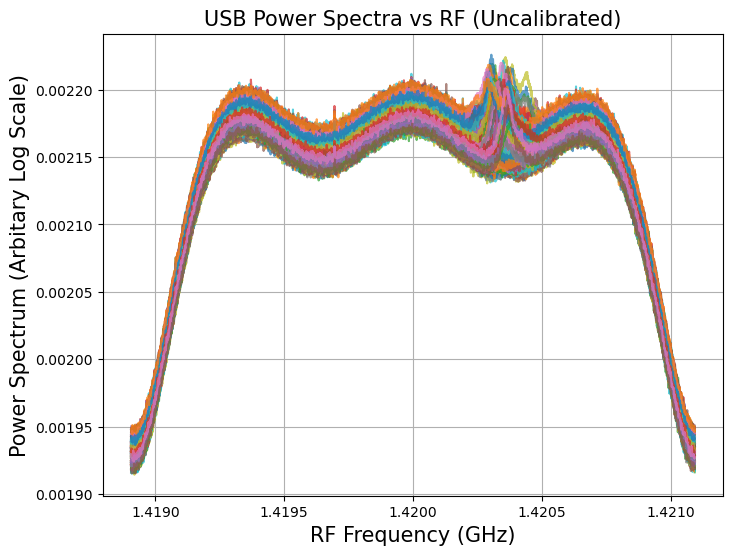

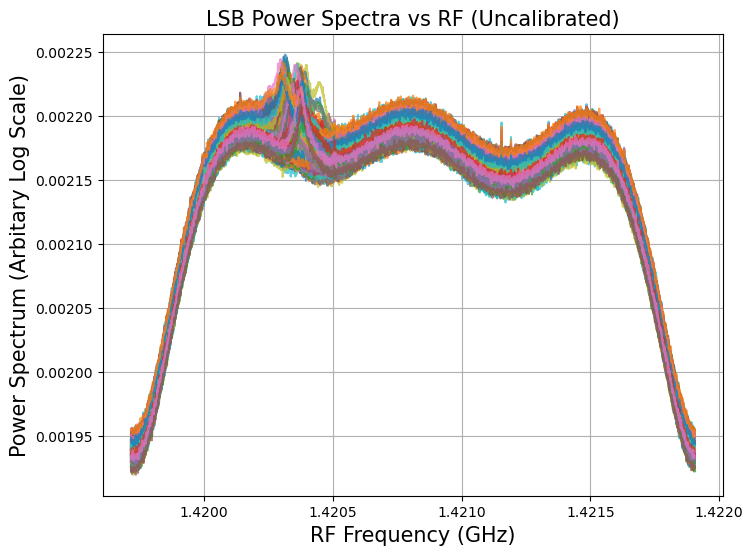

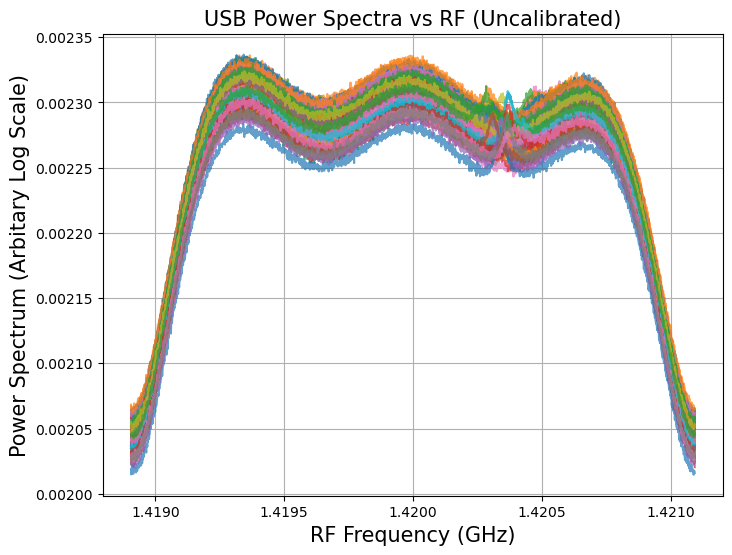

In [262]:
mask = (1.419995e9, 1.420005e9)
plot_power_spectra(data_4_30[0]["normal"], which="USB", LO=LO_USB)
plot_power_spectra(data_4_30[0]["normal"], which="LSB", LO=LO_LSB, spike_mask_range=mask)
plot_power_spectra(data_4_30[0]["calibration"], which="USB", LO=LO_USB)

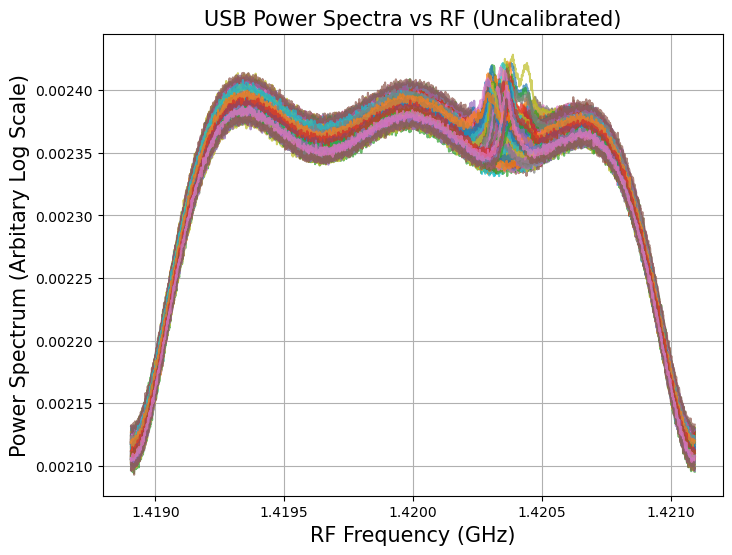

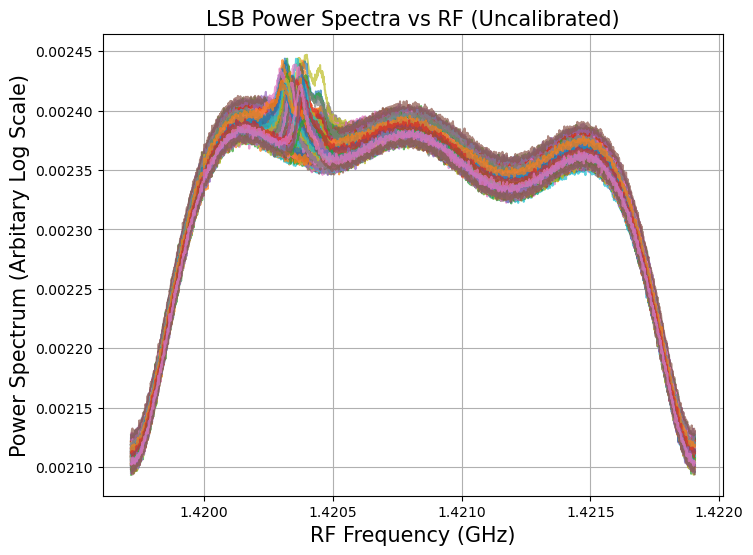

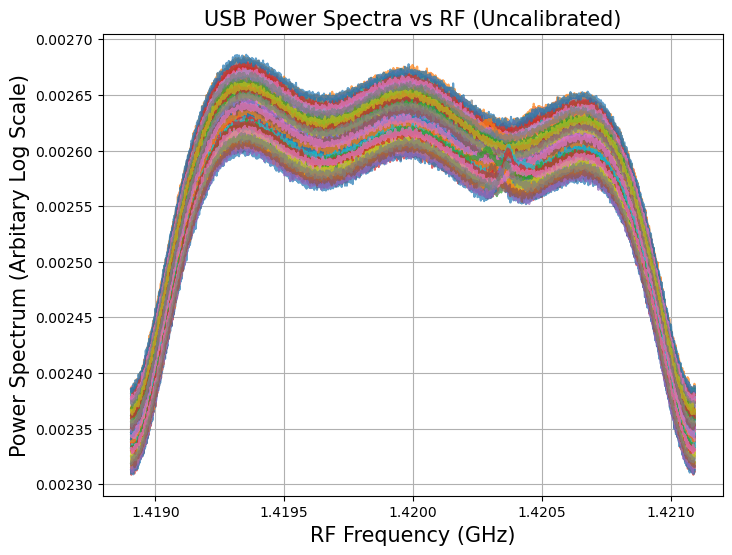

In [263]:
mask = (1.419995e9, 1.420005e9)
plot_power_spectra(data_4_30[1]["normal"], which="USB", LO=LO_USB)
plot_power_spectra(data_4_30[1]["normal"], which="LSB", LO=LO_LSB, spike_mask_range=mask)
plot_power_spectra(data_4_30[1]["calibration"], which="USB", LO=LO_USB)

# Line Shape, Gain, Calibration

In [284]:
lat, lon = ugradio.leo.lat, ugradio.leo.lon
alt = ugradio.leo.alt

def timestampToJD(timestamp):
    t = Time(timestamp, format='isot', scale='utc')  # ISO-8601 format with UTC
    return t.jd

def onlineOfflineSpectra(points, normalize=False, spike_range=None) -> Dict[Tuple[float, float], Dict[str, np.ndarray]]:
    temp_storage: Dict[Tuple[float, float], Dict[str, np.ndarray]] = {}
    freqs = fftfreq(WINDOW, 1/SAMPLE_RATE) + LO_LSB
    freqs_lsb = fftshift((freqs))

    for point in points:
        key = (round(point.l, 3), round(point.b, 3))
        if key not in temp_storage:
            temp_storage[key] = {"USB": None, "LSB": None, "ra": None, "dec": None, "timestamp": None}

        if point.USB is not None:
            temp_storage[key]["USB"] = point.USB
        if point.LSB is not None:
            temp_storage[key]["LSB"] = point.LSB

        temp_storage[key]["ra"] = point.ra
        temp_storage[key]["dec"] = point.dec
        temp_storage[key]["timestamp"] = point.timestamp

    result: Dict[Tuple[float, float], Dict[str, np.ndarray]] = {}

    for (l, b), spectra in temp_storage.items():
        usb = spectra["USB"]
        lsb = spectra["LSB"]
        ra = spectra["ra"]
        dec = spectra["dec"]
        timestamp = spectra["timestamp"]

        if usb is None or lsb is None:
            # skip incomplete points
            continue

        if normalize:
            usb = usb / np.max(usb)
            lsb = lsb / np.max(lsb)

        if spike_range:
            lsb = mask_and_resample_spike(freqs_lsb, lsb, spike_range)

        mid = len(usb) // 2
        online, offline = np.zeros(len(usb)), np.zeros(len(usb))
        online[mid:], offline[mid:] = lsb[mid:], usb[mid:]
        online[:mid], offline[:mid] = usb[:mid], lsb[:mid]

        line_shape = online / offline
        jd = timestampToJD(timestamp)

        result[(l, b)] = {
            "online": online,
            "offline": offline,
            "line_shape": line_shape,
            "ra": ra,
            "dec": dec,
            "jd": jd
        }

    return result

def plot_lineshapes(online_offline_data, corrected=False, xlim=None, ylim=None, title_extra=""):
    plt.figure(figsize=graphSizeSingle)
    freqs = fftfreq(WINDOW, 1/SAMPLE_RATE) + LO_USB
    freqs = fftshift(freqs)[bounds[0]:bounds[1]]
    mid = len(freqs) // 2
    v = np.zeros(len(freqs) - mid)
    v = -c * ((freqs[mid:] - LINE_FREQ) / LINE_FREQ)
    #v = np.zeros(len(freqs))
    #v = -c * ((freqs - LINE_FREQ) / LINE_FREQ)
    v_corrections = []

    for (l, b), spectra in online_offline_data.items():
        lineshape = spectra["line_shape"]
        lineshape = fftshift(lineshape[bounds[0]:bounds[1]])[mid:]
        #lineshape = fftshift(lineshape[bounds[0]:bounds[1]])

        baseline_mask = (v < 0) | (v > 25000)
        poly_coeffs = np.polyfit(v[baseline_mask], lineshape[baseline_mask], deg=1)
        baseline_fit = np.polyval(poly_coeffs, v)
        lineshape = (lineshape - baseline_fit)

        label = f"(l={l:.1f}, b={b:.1f})"

        if corrected:
            ra = spectra["ra"]
            dec = spectra["dec"]
            jd = spectra["jd"]
            v_projected = ugradio.doppler.get_projected_velocity(ra, dec, jd, lat, lon, alt)
            v_corrected = v - v_projected
            v_corrections.append((v, v_projected, v_corrected))

            print(f"JD: {jd:.2f}, RA: {ra:.2f}, Dec: {dec:.2f}")
            print(f"v_projected: {v_projected:.2f} km/s")

            plt.plot(v_corrected / 1e3, lineshape, alpha=0.7, label=label)

        else:
            plt.plot(v / 1e3, lineshape, alpha=0.7, label=label)

    plt.xlabel("Observed Doppler Velocity (km/s)", fontsize=axisSize)
    plt.ylabel("Line Shape (Online Data / Offline Data)", fontsize=axisSize)
    plt.title(f"Overlayed Line Shapes {title_extra}", size=titleSize)
    plt.grid()
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize, ncol=2)  # 2 columns for compactness
    plt.show()

    return v_corrections

In [265]:
def calculate_tsys(power_spectrum):
    # Symmetrize the power spectrum to force cosine iFFT
    n = len(power_spectrum)
    sym_power = np.concatenate((power_spectrum, power_spectrum[::-1]))
    
    # Inverse FFT
    autocorr = np.fft.ifft(sym_power).real
    
    # T_sys is the first lag of autocorrelation
    T_sys = autocorr[0]
    return T_sys

def find_gain_per_point_from_data(observation_data, calibration_data, Tsys_increment=79.0):
    N_obs = len(observation_data)
    gains = []

    cal_coords = np.array([[p.l, p.b] for p in calibration_data])
    cal_spectra = np.array([p.USB for p in calibration_data])

    for i, obs in enumerate(observation_data):
        if obs.USB is None:
            continue
        l_obs, b_obs = obs.l, obs.b
        s_cold = obs.USB

        # Find closest calibration point
        deltas = cal_coords - np.array([l_obs, b_obs])
        distances = np.sqrt((deltas[:,0]*np.cos(np.radians(b_obs)))**2 + (deltas[:,1])**2)
        nearest_idx = np.argmin(distances)
        s_cal = cal_spectra[nearest_idx]

        #Tsys_cold = np.fft.ifft(s_cold)
        #Tsys_cal = Tsys_cold + Tsys_increment

        bottom_sum = np.sum(s_cal - s_cold)
        
        l = round(l_obs, 3)
        b = round(b_obs, 3)

        try:
            G = (Tsys_increment * np.sum(s_cold)) / bottom_sum
        except Exception as e:
            print("Denominator = 0")
            G = 0
        gains.append((l, b, G))
        print(G)

    return gains 

In [266]:
def apply_gain_to_line_shapes(gains_list, online_offline_data):
    calibrated_data: Dict[Tuple[float, float], Dict[str, np.ndarray]] = {}

    gain_dict = {(l, b): gain for (l, b, gain) in gains_list}

    for coord, point in online_offline_data.items():
        if coord in gain_dict:
            if coord not in calibrated_data:
                calibrated_data[coord] = {"line": None, "ra": None, "dec": None, "jd": None}

            gain = gain_dict[coord]
            calibrated_line_shape = point["line_shape"] * gain

            calibrated_data[coord]["line"] = calibrated_line_shape
            calibrated_data[coord]["ra"] = point["ra"]
            calibrated_data[coord]["dec"] = point["dec"]
            calibrated_data[coord]["jd"] = point["jd"]
        else:
            print(f"Warning: No gain found for coordinate {coord}. Skipping.")
    
    return calibrated_data

In [267]:
def plot_calibrated_tsky(data_dict, points_to_plot, corrected=False, xlim=None, ylim=None, title_extra=""):
    plt.figure(figsize=graphSizeSingle)
    freqs = fftfreq(WINDOW, 1/SAMPLE_RATE) + LINE_FREQ
    freqs = fftshift(freqs)[bounds[0]:bounds[1]]
    mid = len(freqs) // 2
    v = np.zeros(len(freqs) - mid)
    v = -c * ((freqs[mid:] - LINE_FREQ) / LINE_FREQ)

    for l_b in points_to_plot:
        if l_b not in data_dict:
            print(f"Warning: (l, b) = {l_b} not found in data.")
            continue
        
        spectrum = data_dict[l_b]["line"]
        label = f"(l={l_b[0]:.1f}, b={l_b[1]:.1f})"

        if corrected:
            ra = data_dict[l_b]["ra"]
            dec = data_dict[l_b]["dec"]
            jd = data_dict[l_b]["jd"]
            v_projected = ugradio.doppler.get_projected_velocity(ra, dec, jd, lat, lon, alt)
            print(f"v_projected = {v_projected}")
            v = v - v_projected

        plt.plot(v / 1e3, spectrum[mid+5:-5], alpha=0.7, label=label)
    plt.xlabel(f"Doppler Velocity (km/s)", fontsize=axisSize)
    plt.ylabel(r"$T_{\rm sky}$ (K)", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(f"Calibrated T_sky Spectra {title_extra}", fontsize=titleSize)
    plt.legend(fontsize=10)
    plt.grid()
    plt.show()

def gaussian(x, amp, mean, sigma, offset):
    return amp * np.exp(-(x - mean)**2 / (2 * sigma**2)) + offset

def plot_calibrated_tsky_and_fit(data_dict, points_to_plot, velocity_axis, fit_range=None, xlim=None, ylim=None, title_extra=""):
    """
    Plot calibrated T_sky line shapes for selected (l, b) points and fit Gaussians.

    Parameters:
    - data_dict: dict mapping (l, b) -> calibrated temperature array
    - points_to_plot: list of (l, b) tuples to plot
    - velocity_axis: np.ndarray, velocity array matching spectra
    - fit_range: tuple (v_min, v_max) for Gaussian fitting window
    - xlim, ylim: optional x and y axis limits
    - title_extra: str, extra title text

    Returns:
    - map_data_list: list of MapData objects (l, b, mean_velocity, brightness)
    """
    plt.figure(figsize=(10, 6))
    map_data_list = []

    for l_b in points_to_plot:
        if l_b not in data_dict:
            print(f"Warning: (l, b) = {l_b} not found in data.")
            continue
        
        spectrum = data_dict[l_b]
        label = f"(l={l_b[0]:.1f}, b={l_b[1]:.1f})"
        
        plt.plot(velocity_axis, spectrum, label=label, alpha=0.7)

        # Gaussian fitting part
        if fit_range:
            v_min, v_max = fit_range
            fit_mask = (velocity_axis >= v_min) & (velocity_axis <= v_max)
            v_fit = velocity_axis[fit_mask]
            T_fit = spectrum[fit_mask]
            
            if len(v_fit) < 5:
                print(f"Warning: Not enough points to fit for {l_b}.")
                continue
            
            # Initial guess: [amp, mean, sigma, offset]
            amp_guess = np.max(T_fit) - np.min(T_fit)
            mean_guess = v_fit[np.argmax(T_fit)]
            sigma_guess = (v_max - v_min) / 6  # rough guess
            offset_guess = np.min(T_fit)
            
            p0 = [amp_guess, mean_guess, sigma_guess, offset_guess]
            
            try:
                popt, _ = curve_fit(gaussian, v_fit, T_fit, p0=p0)
                amp, mean, sigma, offset = popt
                brightness = amp * sigma * np.sqrt(2 * np.pi)  # Gaussian integral

                # Save into MapData
                map_data = MapData(l=l_b[0], b=l_b[1], velocity=mean, brightness=brightness)
                map_data_list.append(map_data)

                # Plot the fitted Gaussian
                v_fine = np.linspace(v_min, v_max, 200)
                plt.plot(v_fine, gaussian(v_fine, *popt), '--', alpha=0.7)

            except RuntimeError:
                print(f"Fit failed for point {l_b}")

    plt.xlabel("Velocity (km/s)", fontsize=14)
    plt.ylabel(r"$T_{\rm sky}$ (K)", fontsize=14)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(f"Calibrated T_sky Spectra with Gaussian Fits {title_extra}", fontsize=16)
    #plt.legend(fontsize=10)
    plt.grid()
    plt.show()

    return map_data_list

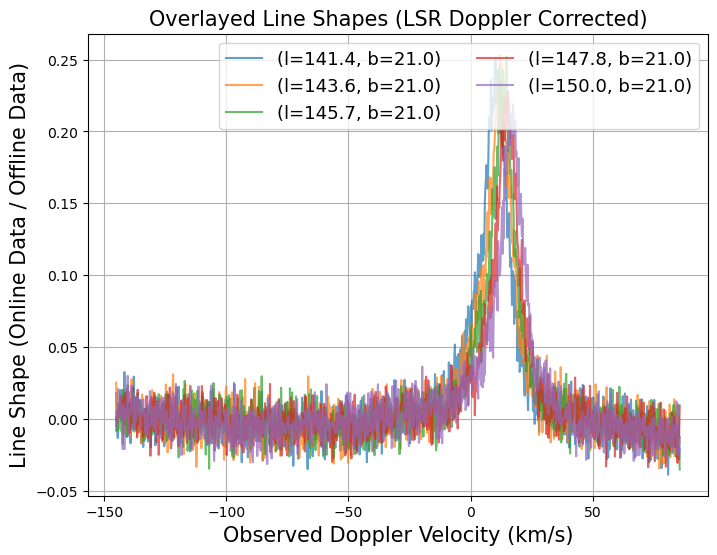

JD: 2460795.39, RA: 86.88, Dec: 72.07
v_projected: -14898.31 km/s
JD: 2460795.40, RA: 89.28, Dec: 70.22
v_projected: -15682.76 km/s
JD: 2460795.40, RA: 91.35, Dec: 68.36
v_projected: -16452.58 km/s
JD: 2460795.41, RA: 93.17, Dec: 66.49
v_projected: -17209.24 km/s
JD: 2460795.42, RA: 94.80, Dec: 64.60
v_projected: -17949.86 km/s


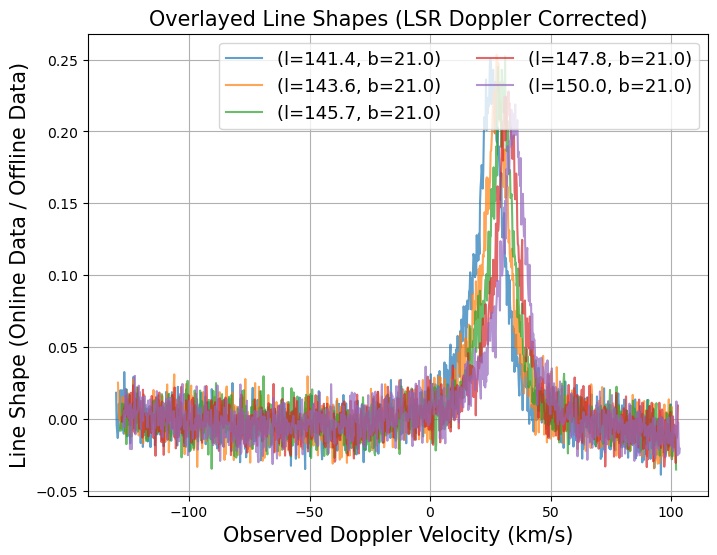

5
v_corrections: [(array([  85638.47988305,   85411.75404852,   85185.02821399, ...,
       -144714.96799856, -144941.69383309, -145168.41966762]), -14898.314389176776, array([ 100536.79427222,  100310.06843769,  100083.34260317, ...,
       -129816.65360938, -130043.37944391, -130270.10527844])), (array([  85638.47988305,   85411.75404852,   85185.02821399, ...,
       -144714.96799856, -144941.69383309, -145168.41966762]), -15682.759093565754, array([ 101321.23897661,  101094.51314208,  100867.78730755, ...,
       -129032.20890499, -129258.93473952, -129485.66057405])), (array([  85638.47988305,   85411.75404852,   85185.02821399, ...,
       -144714.96799856, -144941.69383309, -145168.41966762]), -16452.58170837486, array([ 102091.06159142,  101864.33575689,  101637.60992236, ...,
       -128262.38629018, -128489.11212471, -128715.83795924])), (array([  85638.47988305,   85411.75404852,   85185.02821399, ...,
       -144714.96799856, -144941.69383309, -145168.41966762]), -17209.239

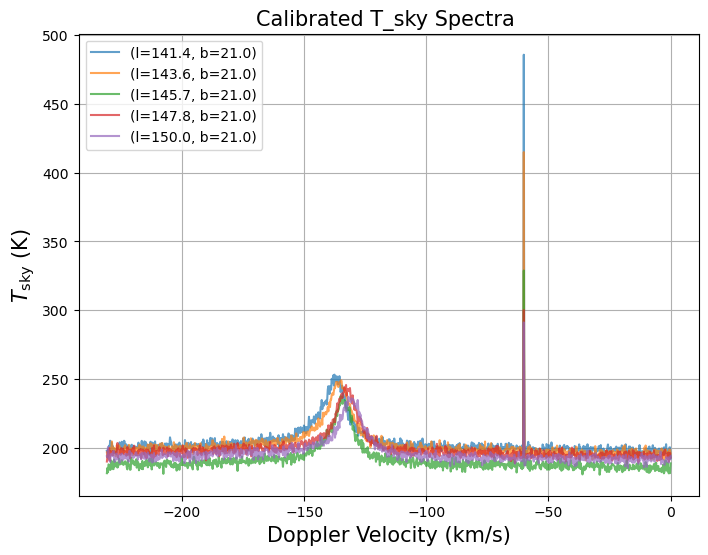

In [285]:
online_offline_data = onlineOfflineSpectra(data_4_30[0]["normal"][0:10], spike_range=(1.419995e9, 1.420005e9))
v_corrections = plot_lineshapes(online_offline_data, corrected=False, title_extra="(LSR Doppler Corrected)")
v_corrections = plot_lineshapes(online_offline_data, corrected=True, title_extra="(LSR Doppler Corrected)")

print(len(v_corrections))
print(f"v_corrections: {v_corrections}")

#print(f"Max Velocity Correction: {max(v_corrections)}")
#print(f"Min Velocity Correction: {min(v_corrections)}")

gains = find_gain_per_point_from_data(data_4_30[0]["normal"], data_4_30[0]["calibration"])   

max_g, min_g = max(gains, key=lambda x: x[2]), min(gains, key=lambda x: x[2])
print(f"Max Gain: {max_g[2]} at (l, b) = ({max_g[0]}, {max_g[1]})")
print(f"Min Gain: {min_g[2]} at (l, b) = ({min_g[0]}, {min_g[1]})")


T_sky = apply_gain_to_line_shapes(gains, online_offline_data)
plot_calibrated_tsky(T_sky, T_sky.keys(), corrected=False)

# Mapping

In [ ]:
@dataclass
class MapData:
    l: float
    b: float
    velocity: float
    brightness: float

test_points = []
for b in np.arange(15, 52, 2):
    delta_l = 2 / np.cos(np.radians(b))
    for l in np.arange(105, 162, delta_l):
        p = MapData(
            l=l, 
            b=b, 
            velocity=np.random.randint(-50, 50), 
            brightness=np.random.randint(0, 20)
        )
        test_points.append(p)
    
print(test_points)

[MapData(l=105.0, b=15, velocity=47, brightness=15), MapData(l=107.07055236082016, b=15, velocity=43, brightness=3), MapData(l=109.14110472164032, b=15, velocity=20, brightness=17), MapData(l=111.21165708246048, b=15, velocity=22, brightness=10), MapData(l=113.28220944328064, b=15, velocity=-40, brightness=13), MapData(l=115.3527618041008, b=15, velocity=37, brightness=3), MapData(l=117.42331416492095, b=15, velocity=-41, brightness=15), MapData(l=119.49386652574111, b=15, velocity=-16, brightness=13), MapData(l=121.56441888656127, b=15, velocity=18, brightness=9), MapData(l=123.63497124738143, b=15, velocity=-39, brightness=14), MapData(l=125.70552360820159, b=15, velocity=24, brightness=14), MapData(l=127.77607596902175, b=15, velocity=22, brightness=15), MapData(l=129.8466283298419, b=15, velocity=-6, brightness=0), MapData(l=131.91718069066206, b=15, velocity=-36, brightness=5), MapData(l=133.98773305148222, b=15, velocity=17, brightness=13), MapData(l=136.05828541230238, b=15, vel

In [ ]:
def velocity_to_rgb(velocity, vmin, vmax):
    # Normalize velocity between 0 and 1
    norm_v = (velocity - vmin) / (vmax - vmin)
    norm_v = np.clip(norm_v, 0, 1)

    if norm_v < 0.5:
        r = 2 * norm_v
        g = 2 * norm_v
        b = 1.0
    else:
        r = 1.0
        g = 2 * (1 - norm_v)
        b = 2 * (1 - norm_v)
        
    return (r, g, b)

def brightness_to_alpha(brightness, bmin, bmax):
    norm_b = (brightness - bmin) / (bmax - bmin)
    norm_b = np.clip(norm_b, 0, 1)
    return norm_b

In [ ]:
def plot_cylindrical(points, size=10, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)

    v_min, v_max = min([p.velocity for p in points]), max([p.velocity for p in points])
    b_min, b_max = min([p.brightness for p in points]), max([p.brightness for p in points])

    l_list = [p.l for p in points]
    b_list = [p.b for p in points]
    v_list = [p.velocity for p in points]
    a_list = [brightness_to_alpha(p.brightness, b_min, b_max) for p in points]

    cmap = plt.cm.coolwarm
    norm = mpl.colors.Normalize(vmin=v_min, vmax=v_max)

    sc = plt.scatter(l_list, b_list, c=v_list, cmap=cmap, norm=norm, s=size, alpha=a_list)
    cbar = plt.colorbar(sc)
    cbar.set_label("Velocity (km/s)", fontsize=axisSize)

    plt.title("Cylindrical Equidistant Projection", fontsize=titleSize)
    plt.xlabel("Galactic Longitude (degrees)", fontsize=axisSize)
    plt.ylabel("Galactic Latitude (degrees)", fontsize=axisSize)

    plt.grid(True)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.show()

def plot_stereographic(points, center_l=135, center_b=32, size=10, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)

    v_min, v_max = min([p.velocity for p in points]), max([p.velocity for p in points])
    b_min, b_max = min([p.brightness for p in points]), max([p.brightness for p in points])

    x_list = []
    y_list = []
    v_list = []
    a_list = []
    for p in points:
        delta_lon = np.radians(p.l - center_l)
        lat = np.radians(p.b)
        R = np.tan(0.5 * (np.pi/2 - lat))
        x = R * np.sin(delta_lon)
        y = R * np.cos(delta_lon)
        x_list.append(x)
        y_list.append(y)
        v_list.append(p.velocity)
        a_list.append(brightness_to_alpha(p.brightness, b_min, b_max))

    cmap = plt.cm.coolwarm
    norm = mpl.colors.Normalize(vmin=v_min, vmax=v_max)

    sc = plt.scatter(x_list, y_list, c=v_list, cmap=cmap, norm=norm, s=size, alpha=a_list)
    cbar = plt.colorbar(sc)
    cbar.set_label("Velocity (km/s)", fontsize=axisSize)

    plt.title("Stereographic Projection", fontsize=titleSize)
    plt.xlabel("X = R cos(lon)", fontsize=axisSize)
    plt.ylabel("Y = R sin(lon)", fontsize=axisSize)

    plt.grid(True)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.show()

def plot_mollweide(points, size=10, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    ax = plt.subplot(111, projection="mollweide")

    v_min, v_max = min([p.velocity for p in points]), max([p.velocity for p in points])
    b_min, b_max = min([p.brightness for p in points]), max([p.brightness for p in points])

    lon_list = [np.radians(p.l) for p in points]
    lat_list = [np.radians(p.b) for p in points]
    v_list = [p.velocity for p in points]
    a_list = [brightness_to_alpha(p.brightness, b_min, b_max) for p in points]

    cmap = plt.cm.coolwarm
    norm = mpl.colors.Normalize(vmin=v_min, vmax=v_max)

    sc = ax.scatter(lon_list, lat_list, c=v_list, cmap=cmap, norm=norm, s=size, alpha=a_list)
    cbar = plt.colorbar(sc, orientation="horizontal", pad=0.07)
    cbar.set_label("Velocity (km/s)", fontsize=axisSize)

    plt.title("Mollweide Projection", fontsize=titleSize)
    plt.xlabel("Galactic Longitude (degrees)", fontsize=axisSize)
    plt.ylabel("Galactic Latitude (degrees)", fontsize=axisSize)

    plt.grid(True)
    plt.show()

def plot_cartopy(points, projection='mollweide', size=10, focus_area=False, show_map_background=False, show_grid_labels=True):
    if projection == 'cylindrical':
        proj = ccrs.PlateCarree()  # standard longitude/latitude
    elif projection == 'stereographic':
        proj = ccrs.Stereographic(central_longitude=135, central_latitude=32)
    elif projection == 'mollweide':
        proj = ccrs.Mollweide(central_longitude=0)
    else:
        raise ValueError("Unknown projection type")
    
    fig = plt.figure(figsize=graphSizeSingle)
    ax = plt.axes(projection=proj)

    if not focus_area:
        ax.set_global()
    else:
        ax.set_extent([105, 160, 15, 50], crs=ccrs.PlateCarree())

    if show_map_background:
        ax.coastlines(resolution='110m', color='gray', linewidth=0.5)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=show_grid_labels, color='lightgray', linewidth=0.5)
    if show_grid_labels:
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 10}
        gl.ylabel_style = {'size': 10}
        gl.xformatter = mpl.ticker.FuncFormatter(lambda x, _: f"{x:.0f}°")
        gl.yformatter = mpl.ticker.FuncFormatter(lambda y, _: f"{y:.0f}°")
        gl.xlocator = mpl.ticker.FixedLocator(np.arange(105, 165, 10))
        gl.ylocator = mpl.ticker.FixedLocator(np.arange(10, 55, 10))
        
    fig.text(0.5, 0.05, 'Galactic Longitude (degrees)', ha='center', fontsize=axisSize)
    fig.text(0.05, 0.5, 'Galactic Latitude (degrees)', va='center', rotation='vertical', fontsize=axisSize)

    l_list = [p.l for p in points]
    b_list = [p.b for p in points]
    v_list = [p.velocity for p in points]
    bright_list = [p.brightness for p in points]

    v_min, v_max = min([v for v in v_list]), max([v for v in v_list])
    b_min, b_max = min([b for b in bright_list]), max([b for b in bright_list])
    a_list = [brightness_to_alpha(b, b_min, b_max) for b in bright_list]

    cmap = plt.cm.coolwarm
    norm = mpl.colors.Normalize(vmin=v_min, vmax=v_max)
    sc = ax.scatter(
        l_list, b_list, c=v_list, cmap=cmap, norm=norm,
        s=size, alpha=a_list, transform=ccrs.PlateCarree()
    )

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(sc, cax=cax, orientation="vertical")
    cbar.set_label("Velocity (km/s)", fontsize=axisSize)

    ax.set_title(f"Cartopy Map ({projection.title()} Projection)", fontsize=16)
    #plt.xlabel(xlabel, fontsize=axisSize)
    #plt.ylabel(ylabel, fontsize=axisSize)
    plt.grid()
    plt.show()

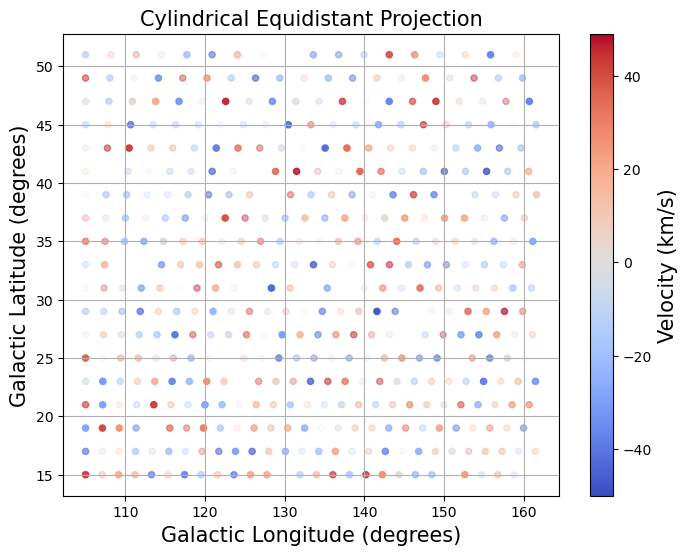

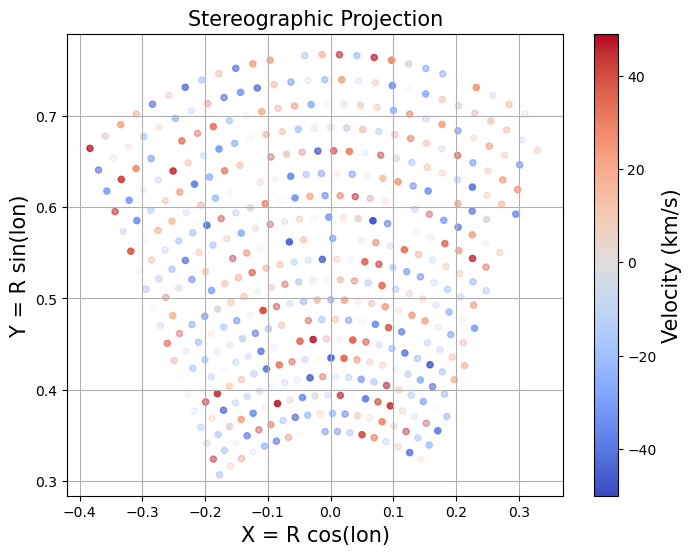

KeyError: 'projection'

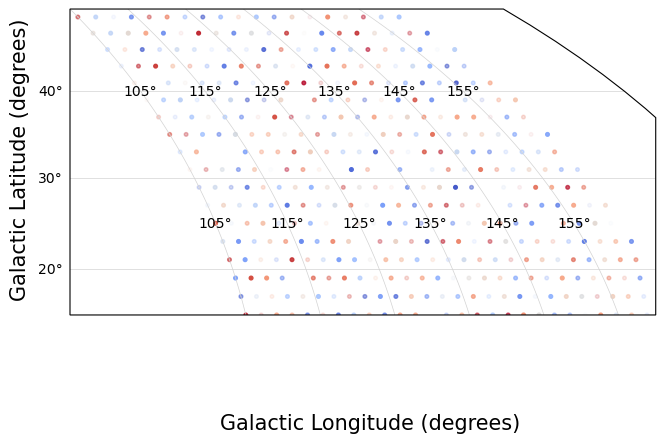

In [ ]:
plot_cylindrical(test_points, size=20)
plot_stereographic(test_points, size=20)

plot_cartopy(test_points, size=7, focus_area=True)